In [1]:
# pip install pandas 

In [2]:
import pickle
import time
from datetime import datetime, timedelta
from easydict import EasyDict as edict
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

現貨

In [3]:
symbol = 'BTCUSDT'
f_symbol = "BTCUSD_PERP"
# freq = '30m'
# freq = '4h'
# freq = '8h'
freq = '1d'

In [4]:
all_klines_table = pd.read_pickle(f"{symbol}_{freq}_spot_k_line_data.pkl")
all_f_klines_table = pd.read_pickle(f"{symbol}_{freq}_future_k_line_data.pkl")

# 合併資料

In [5]:
merge_all_klines_table = all_klines_table[['open_time', 'close', 'open']].merge(
    all_f_klines_table[['open_time', 'close', 'open']], on=['open_time'], 
    suffixes=("_spot", "_future"),
)

In [6]:
merge_all_klines_table['basis'] =merge_all_klines_table['close_spot'] - merge_all_klines_table['close_future']
merge_all_klines_table['basis_rate'] = merge_all_klines_table['basis']/merge_all_klines_table['close_spot'] * 100
merge_all_klines_table.index = merge_all_klines_table['open_time']

# 我們想探討的變數

In [7]:
y = merge_all_klines_table["basis"]

# 畫圖

In [8]:
outpath = "output"

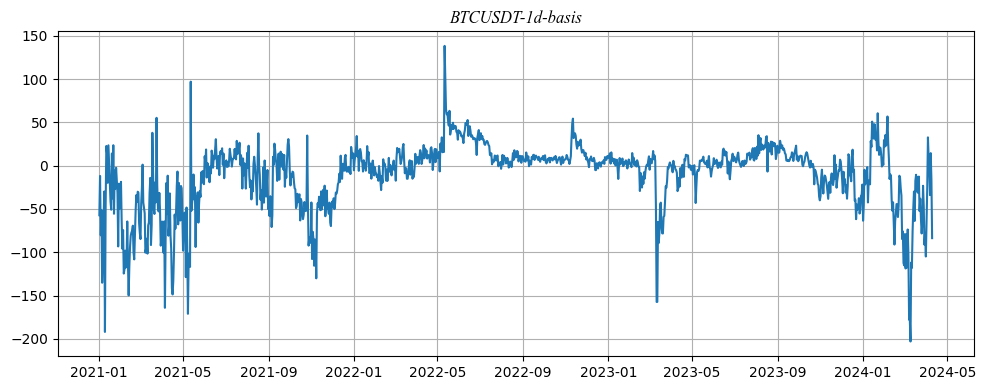

In [9]:
plt.figure(figsize=(10,4))
title = f"{symbol}-{freq}-{y.name}"
plt.title(title, fontdict={'fontname': 'Times New Roman', 'fontstyle': 'italic'})
plt.plot(y)
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(outpath, f"{title}走勢圖.png"))

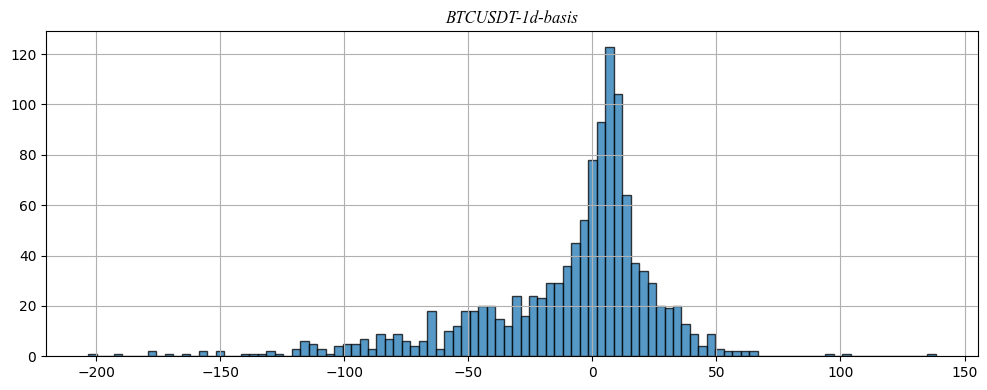

In [10]:
plt.figure(figsize=(10,4))
n, bins, patches = plt.hist(y, bins=100, alpha=0.75, edgecolor='black')
title = f"{symbol}-{freq}-{y.name}"
plt.title(title, fontdict={'fontname': 'Times New Roman', 'fontstyle': 'italic'})
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(outpath, f"{title}分佈圖.png"))

# 敘述性統計

In [11]:
# !pip install arch
# !pip install numpy==1.23.5 --user

In [12]:
from utils import describeData

In [13]:
file_name = f"{symbol}-{freq}-{y.name}"
describeData(y).to_frame().to_csv(os.path.join(outpath, f'{file_name}_describe.csv') )
describeData(y)

count       1195.000000
mean          -9.745155
std           37.532161
min         -203.030000
25%          -23.265000
50%            1.500000
75%           11.120000
max          138.340000
skew          -1.411857
kurtosis       3.237936
Name: basis, dtype: float64

In [14]:
# 單根檢定

In [15]:
title

'BTCUSDT-1d-basis'

In [16]:
from arch import unitroot
adf = unitroot.ADF(y, max_lags=50, method="bic")
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -6.632
P-value                         0.000
Lags                                2
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [17]:
pp = unitroot.PhillipsPerron(y)
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -13.450
P-value                         0.000
Lags                               23
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [18]:
kpss = unitroot.KPSS(y)
print(kpss.summary().as_text())

    KPSS Stationarity Test Results   
Test Statistic                  0.998
P-value                         0.003
Lags                               19
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


# acf, pacf

In [19]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf

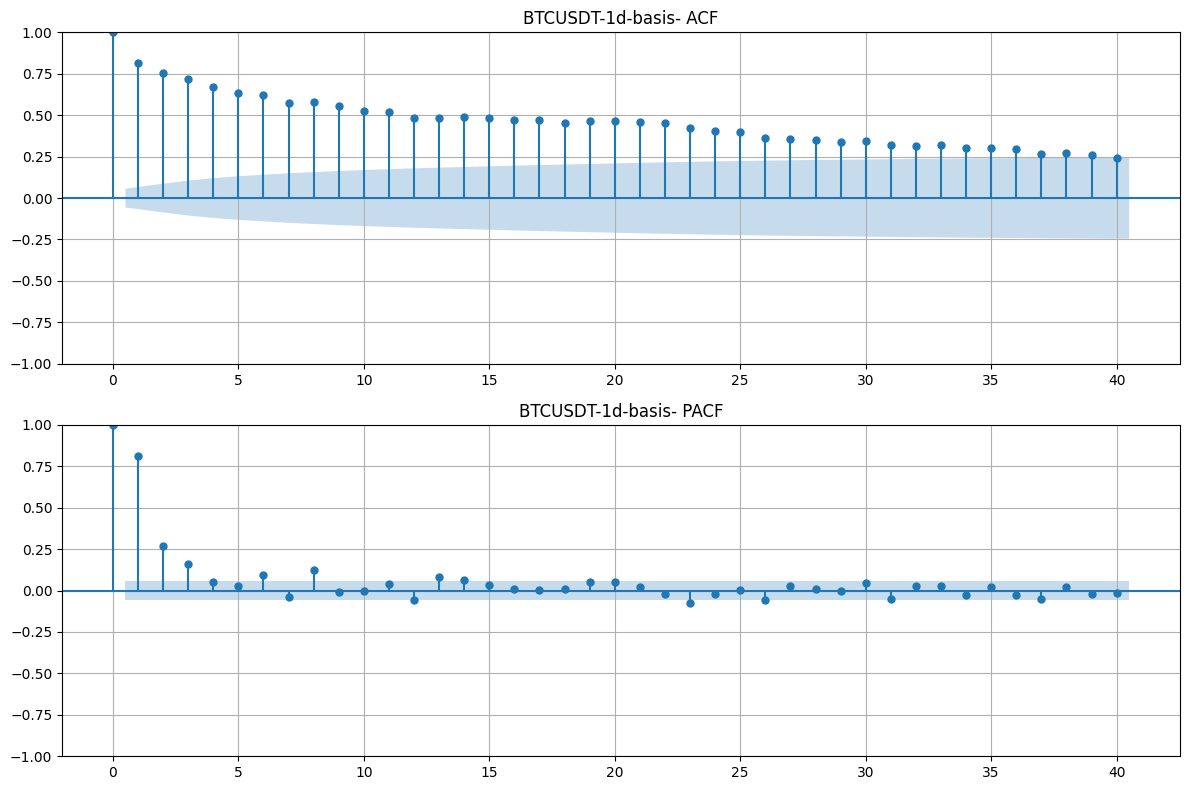

In [20]:
title = f"{symbol}-{freq}-{y.name}"
fig = plt.figure(figsize=(12, 8))
# plt.title(title, fontdict={'fontname': 'Times New Roman', 'fontstyle': 'italic'})
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y, lags=40, ax=ax1, title=f"{title}- ACF")
plt.grid()
plt.tight_layout()
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y, lags=40, ax=ax2, title=f"{title}- PACF")
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(outpath, f"{title}_acf_pacf_分佈圖.png"))

In [21]:
## 連第0期也有呈現
## if qstat=True, returns the Ljung-Box q statistic (coefficient, q_stat, prob)
coefficient, q_stat, prob = acf(y, nlags=40, qstat=True)

In [22]:
pd.DataFrame([coefficient, q_stat, prob ], index=["acf", 'q', 'prob']).T

,acf,q,prob
0,1.000000,792.933744,1.855243e-174
1,0.813560,1471.893283,0.000000e+00
2,0.752508,2088.113079,0.000000e+00
3,0.716597,2630.068295,0.000000e+00
4,0.671748,3111.302802,0.000000e+00
5,0.632734,3575.881083,0.000000e+00
6,0.621426,3975.073026,0.000000e+00
7,0.575795,4381.438798,0.000000e+00
8,0.580701,4752.323348,0.000000e+00
9,0.554537,5088.981216,0.000000e+00


In [23]:
pacf_value, pacf_c = pacf(y,  nlags=40, alpha=.05)

In [24]:
pd.DataFrame([pacf_value, pacf_c ], index=["pacf ", "confint"], columns=["" for _ in range(len(pacf_value))]).T

,pacf,confint
,1.0,"[1.0, 1.0]"
,0.814241,"[0.7575438397502764, 0.8709388994626687]"
,0.26937,"[0.21267221575912865, 0.3260672754715208]"
,0.16203,"[0.10533294487769906, 0.21872800459009123]"
,0.051455,"[-0.005242568065479229, 0.10815249164691296]"
,0.029438,"[-0.027259182091263847, 0.08613587762112833]"
,0.09679,"[0.040092557566550745, 0.15348761727894292]"
,-0.036702,"[-0.09339940858768683, 0.01999565112470534]"
,0.123094,"[0.06639604160887419, 0.17979110132126638]"
,-0.005593,"[-0.062290343399462274, 0.051104716312929906]"


https://www.statsmodels.org/devel/examples/notebooks/generated/tsa_arma_0.html

In [25]:
import pandas as pd
import numpy as np 
np.set_printoptions( precision= 5, suppress=True )

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot
import statsmodels.api as sm
import numpy as np
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_predict

In [26]:
ARIMA?

Init signature:
ARIMA(
    endog,
    exog=None,
    order=(0, 0, 0),
    seasonal_order=(0, 0, 0, 0),
    trend=None,
    enforce_stationarity=True,
    enforce_invertibility=True,
    concentrate_scale=False,
    trend_offset=1,
    dates=None,
    freq=None,
    missing='none',
    validate_specification=True,
)
Docstring:     
Autoregressive Integrated Moving Average (ARIMA) model, and extensions

This model is the basic interface for ARIMA-type models, including those
with exogenous regressors and those with seasonal components. The most
general form of the model is SARIMAX(p, d, q)x(P, D, Q, s). It also allows
all specialized cases, including

- autoregressive models: AR(p)
- moving average models: MA(q)
- mixed autoregressive moving average models: ARMA(p, q)
- integration models: ARIMA(p, d, q)
- seasonal models: SARIMA(P, D, Q, s)
- regression with errors that follow one of the above ARIMA-type models

Parameters
----------
endog : array_like, optional
    The observed time-se

In [27]:
p = 1
q = 5

# ARIMA(p, d, q)
arma_model = ARIMA(
    y , 
    order=(p, 0, q), 
    missing='drop',
    # freq=freq
).fit()

C:\Users\jeffg\anaconda3\envs\moody\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\jeffg\anaconda3\envs\moody\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\jeffg\anaconda3\envs\moody\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [28]:
summary = arma_model.summary()
# 殘差檢驗：Ljung-Box統計
Q_test_table = acorr_ljungbox(arma_model.resid, lags=[4, 8, 12], return_df=False)

In [29]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  basis   No. Observations:                 1195
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -5306.072
Date:                Fri, 12 Apr 2024   AIC                          10628.144
Time:                        02:59:19   BIC                          10668.832
Sample:                    01-01-2021   HQIC                         10643.474
                         - 04-09-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.7780     11.204     -0.873      0.383     -31.737      12.181
ar.L1          0.9752      0.009    103.622      0.000       0.957       0.994
ma.L1         -0.4350      0.017    -25.399      0.000      -0.469      -0.401
ma.L2         -0.1032      0.019     -5.378      0.000      -0.141      -0.066
ma.L3          0.0056      0.022      0.259      0.796      -0.037       0.048
ma.L4         -0.0379      0.020     -1.891      0.059      -0.077       0.001
ma.L5         -0.0811      0.022     -3.711      0.000      -0.124      -0.038
sigma2       420.5013      6.284     66.920      0.000     408.186     432.817
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             10735.48
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
Q_test_table

,lb_stat,lb_pvalue
4,0.199735,0.995333
8,23.065122,0.003282
12,36.535971,0.000266


In [31]:
from tqdm import tqdm

In [32]:
def signif(p_val):
    if p_val <= 0.01: return "***"
    elif p_val <= 0.05: return "**"
    elif p_val <= 0.1: return "*"
    else: return ""


In [35]:
all_result_table = pd.DataFrame()
resid_maplist = {}
for pq in tqdm([
    (1,0), 
    (3,0), 
    ((1,7),0), 
    ((1,8),0), 
    ((1,7,8),0), 
    ((1,2,3,7),0),
    ((1,2,3,8),0),
    ((1,2,3,7,8),0),

    (0,1),
    (0,5), 
    (1,1), 
    (1,5), 
    (3,1), 
    ((1,2,3,7,8),1),  
    (3,5), 
    ((1,2,3,7,8),5),  
]):
    p = pq[0]
    q = pq[1]
    
    # ARIMA(p, d, q)
    try:
        arma_model = ARIMA(
            y , 
            order=(p, 0, q), 
            missing='drop',
            # freq=freq
        ).fit()
    except:
        continue
    summary = arma_model.summary()
    # 殘差檢驗：Ljung-Box統計
    Q_test_table = acorr_ljungbox(arma_model.resid, lags=[4, 8, 12], return_df=False)
    
    result_label_list = []
    result_value_list = []
    for res_coef, res_t,res_p, res_name in zip(arma_model.params , arma_model.tvalues, arma_model.pvalues, arma_model.params.index):
        result_label_list.append(f"{res_name}_coef")
        result_value_list.append("%.4f%s"%(res_coef, signif(res_p)))
        result_label_list.append(f"{res_name}_t")
        result_value_list.append("%.4f"%res_t)
        
    result_label_list.append("SSR")
    result_value_list.append("%.4f"% np.sum(arma_model.resid**2))
    
    result_label_list.append("AIC")
    result_value_list.append("%.4f"%arma_model.aic)
        
    result_label_list.append("SBC")
    result_value_list.append("%.4f"%arma_model.bic)
    
    result_label_list.append("Q(4)")
    result_value_list.append("%.4f"%Q_test_table['lb_stat'][4])
    
    result_label_list.append("Q(8)")
    result_value_list.append("%.4f"%Q_test_table['lb_stat'][8])
    
    result_label_list.append("Q(12)")
    result_value_list.append("%.4f"%Q_test_table['lb_stat'][12])
    
    res_table =  pd.DataFrame(result_value_list, index=result_label_list, columns=[f"ARMA({p},{q})"])
    
    all_result_table = pd.concat((all_result_table, res_table), axis=1)
    resid_maplist[f"ARMA({p},{q})"] = arma_model.resid

  0%|                                                                                                                                                                                                                                               | 0/16 [00:00<?, ?it/s]C:\Users\jeffg\anaconda3\envs\moody\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\jeffg\anaconda3\envs\moody\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\jeffg\anaconda3\envs\moody\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
  6%|██████████████▍                                                                 

In [36]:
title = f"{symbol}-{freq}-{y.name}"

In [37]:
all_result_table.loc[result_label_list, :].to_excel(os.path.join(outpath, f"{title}_arma_result.xlsx"))
pd.to_pickle(resid_maplist, os.path.join(outpath, f"{title}_arma_result_resid.pkl"))

In [40]:
all_result_table.loc[result_label_list, :]

,"ARMA(1,0)","ARMA(3,0)","ARMA((1, 7),0)","ARMA((1, 8),0)","ARMA((1, 7, 8),0)","ARMA((1, 2, 3, 7),0)","ARMA((1, 2, 3, 7, 8),0)","ARMA(0,1)","ARMA(0,5)","ARMA(1,1)","ARMA(1,5)","ARMA(3,1)","ARMA((1, 2, 3, 7, 8),1)","ARMA(3,5)","ARMA((1, 2, 3, 7, 8),5)"
const_coef,-10.2000**,-9.7522,-10.5842*,-9.7558,-10.9582,-9.7523,-9.7452,-9.7600***,-9.7536***,-9.7488,-9.7780,-9.8071,-9.7459,-9.7618,-9.8726
const_t,-2.4969,-1.4150,-1.8912,-1.3776,-1.5991,-1.3009,-1.1551,-6.3402,-4.1726,-1.2652,-0.8727,-0.8487,-0.2830,-1.0075,-0.8832
ar.L1_coef,0.8166***,0.5573***,0.7445***,0.7168***,0.7235***,0.5506***,0.5577***,NaN,NaN,0.9409***,0.9752***,1.3708***,0.5006,-0.3090***,0.3732**
ar.L1_t,69.0533,37.1318,56.4835,59.3689,52.9987,35.9511,35.1597,NaN,NaN,105.4897,103.6221,30.7609,1.5570,-3.1003,2.1890
ar.L2_coef,NaN,0.1674***,NaN,NaN,NaN,0.1634***,0.1318***,NaN,NaN,NaN,NaN,-0.2829***,0.5257***,0.6132***,0.3851***
ar.L2_t,NaN,9.9717,NaN,NaN,NaN,9.6960,7.7802,NaN,NaN,NaN,NaN,-9.0200,3.2756,14.6352,2.9339
ar.L3_coef,NaN,0.1619***,NaN,NaN,NaN,0.1494***,0.1507***,NaN,NaN,NaN,NaN,-0.0998***,-0.7377***,0.5972***,0.2959**
ar.L3_t,NaN,9.8658,NaN,NaN,NaN,8.4564,8.7590,NaN,NaN,NaN,NaN,-4.1277,-2.8145,6.9764,2.4920
ar.L7_coef,NaN,NaN,0.1154***,NaN,-0.0293,0.0310*,-0.0691***,NaN,NaN,NaN,NaN,NaN,0.2684,NaN,-0.1505***
ar.L7_t,NaN,NaN,7.8574,NaN,-1.4741,1.9076,-3.7693,NaN,NaN,NaN,NaN,NaN,0.5213,NaN,-4.4600


# 預測

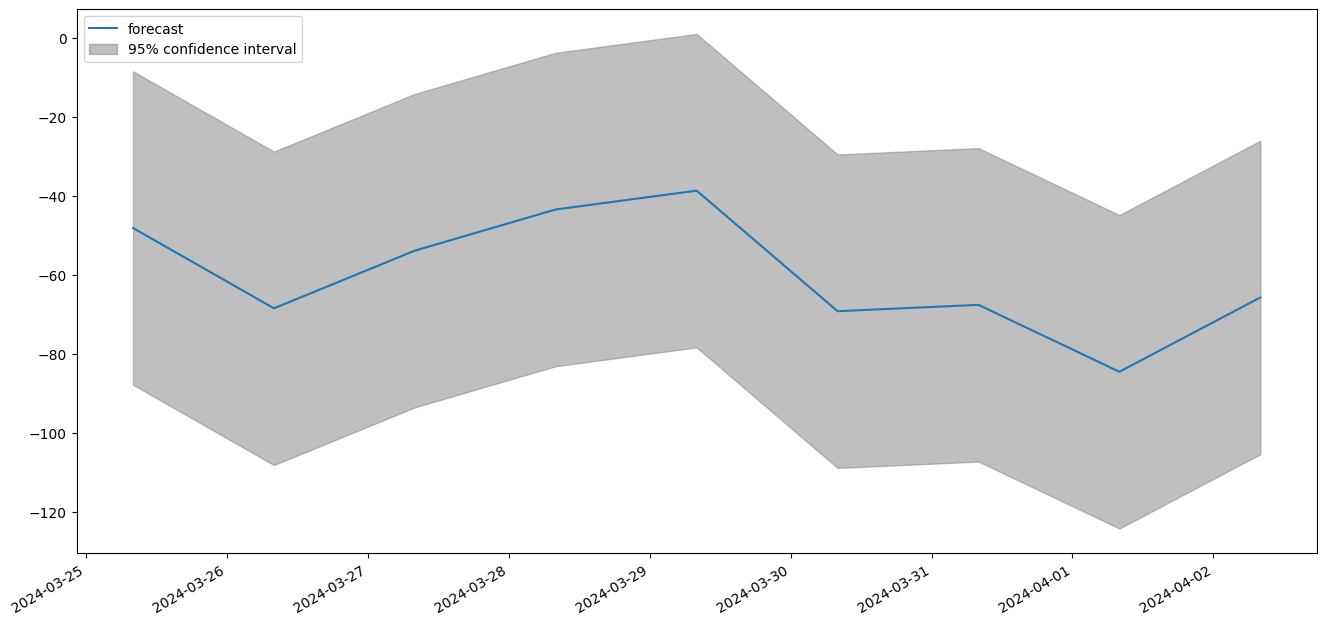

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
fig = plot_predict(arma_model, start="2024-03-25", end="2024-04-02", ax=ax)
legend = ax.legend(loc="upper left")